In [36]:

!pip install imbalanced-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, f1_score, accuracy_score)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization,
                                     Input, GaussianNoise)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, LearningRateScheduler)
import gc
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

from google.colab import drive
drive.mount('/content/drive')

# ============================================================================
# MEMORY OPTIMIZATION UTILITIES
# ============================================================================

def reduce_mem_usage(df, verbose=True):
    """
    Reduce memory usage by downcasting numeric types
    Can reduce memory by 50-80%
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB '
              f'({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')

    return df

# ============================================================================
# FOCAL LOSS
# ============================================================================

def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# ============================================================================
# F1 METRIC
# ============================================================================

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
# ============================================================================
# 1. LOAD DATA WITH MEMORY OPTIMIZATION
# ============================================================================
print("=" * 80)
print("LOADING DATASETS (MEMORY OPTIMIZED)")
print("=" * 80)

train_path = '/content/drive/MyDrive/ML/train_transaction.csv'
test_path = '/content/drive/MyDrive/ML/test_transaction.csv'

# Load only necessary columns - identify important features first
# For fraud detection, these are typically the most important
important_cols = [
    'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'dist1', 'dist2',
    'P_emaildomain', 'R_emaildomain',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D15',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'V12', 'V13', 'V36', 'V37', 'V38', 'V45', 'V46', 'V47', 'V48', 'V49', 'V51', 'V52',
    'V53', 'V54', 'V56', 'V62', 'V70', 'V76', 'V78', 'V82', 'V83', 'V87', 'V90', 'V91'
]

# Load with dtype specification for memory efficiency
dtype_dict = {
    'TransactionDT': 'int32',
    'TransactionAmt': 'float32',
    'card1': 'int16',
    'card2': 'float32',
    'card3': 'float32',
    'addr1': 'float32',
    'addr2': 'float32',
    'dist1': 'float32',
    'dist2': 'float32'
}

print("Loading training data...")
try:
    train_df = pd.read_csv(train_path, usecols=important_cols, dtype=dtype_dict)
except:
    # If important_cols not all present, load all and filter later
    train_df = pd.read_csv(train_path)

print("Loading test data...")
test_cols = [col for col in important_cols if col != 'isFraud']
try:
    test_df = pd.read_csv(test_path, usecols=test_cols, dtype=dtype_dict)
except:
    test_df = pd.read_csv(test_path)

# Apply memory reduction
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nFraud distribution:")
print(train_df['isFraud'].value_counts())
print(f"Fraud rate: {train_df['isFraud'].mean() * 100:.2f}%")

LOADING DATASETS (MEMORY OPTIMIZED)
Loading training data...
Loading test data...
Memory usage decreased from 298.49 MB to 188.67 MB (36.8% reduction)
Memory usage decreased from 252.24 MB to 161.40 MB (36.0% reduction)

Train shape: (590540, 71)
Test shape: (506691, 70)

Fraud distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%


In [38]:
# ============================================================================
# 2. LIGHTWEIGHT PREPROCESSING (MEMORY EFFICIENT)
# ============================================================================
print("\n" + "=" * 80)
print("MEMORY-EFFICIENT PREPROCESSING")
print("=" * 80)

def lightweight_preprocessing(df, is_train=True):
    """
    Lightweight preprocessing focusing on essential features only
    """
    df = df.copy()

    transaction_ids = df['TransactionID'].values

    if is_train:
        target = df['isFraud'].values
        df = df.drop(['isFraud', 'TransactionID'], axis=1)
    else:
        df = df.drop(['TransactionID'], axis=1)
        target = None

    # Identify column types
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    print(f"Numeric: {len(numeric_cols)}, Categorical: {len(categorical_cols)}")

    # ========================================================================
    # Essential Feature Engineering Only
    # ========================================================================

    # Transaction amount (most important feature)
    if 'TransactionAmt' in df.columns:
        df['TransactionAmt_log'] = np.log1p(df['TransactionAmt']).astype('float32')
        df['TransactionAmt_decimal'] = (df['TransactionAmt'] -
                                        df['TransactionAmt'].astype(int)).astype('float32')

    # Time features (second most important)
    if 'TransactionDT' in df.columns:
        df['TransactionDT_hour'] = ((df['TransactionDT'] % (24 * 3600)) // 3600).astype('int8')
        df['TransactionDT_dayofweek'] = ((df['TransactionDT'] // (24 * 3600)) % 7).astype('int8')

    # V-features aggregation (jika ada V columns)
    v_cols = [col for col in df.columns if col.startswith('V') and col[1:].isdigit()]
    if len(v_cols) > 0:
        print(f"  → Creating V-feature aggregations from {len(v_cols)} V-columns")
        df['V_sum'] = df[v_cols].sum(axis=1).astype('float32')
        df['V_mean'] = df[v_cols].mean(axis=1).astype('float32')
        df['V_std'] = df[v_cols].std(axis=1).astype('float32')

    # C-features aggregation
    c_cols = [col for col in df.columns if col.startswith('C') and col[1:].isdigit()]
    if len(c_cols) > 0:
        print(f"  → Creating C-feature aggregations from {len(c_cols)} C-columns")
        df['C_sum'] = df[c_cols].sum(axis=1).astype('float32')
        df['C_mean'] = df[c_cols].mean(axis=1).astype('float32')

    # D-features aggregation
    d_cols = [col for col in df.columns if col.startswith('D') and col[1:].isdigit()]
    if len(d_cols) > 0:
        print(f"  → Creating D-feature aggregations from {len(d_cols)} D-columns")
        df['D_sum'] = df[d_cols].sum(axis=1).astype('float32')
        df['D_mean'] = df[d_cols].mean(axis=1).astype('float32')

    # Email domain features
    if 'P_emaildomain' in df.columns:
        df['P_emaildomain_isNull'] = df['P_emaildomain'].isna().astype('int8')
    if 'R_emaildomain' in df.columns:
        df['R_emaildomain_isNull'] = df['R_emaildomain'].isna().astype('int8')

    # ProductCD one-hot encoding
    if 'ProductCD' in df.columns:
        product_dummies = pd.get_dummies(df['ProductCD'], prefix='Prod', dtype='int8')
        df = pd.concat([df, product_dummies], axis=1)

    # ========================================================================
    # Efficient Missing Value Handling
    # ========================================================================

    # For numeric: fill with -999 (lighter than median calculation)
    for col in numeric_cols:
        if df[col].isnull().any():
            df[col].fillna(-999, inplace=True)

    # For categorical: fill with 'Unknown' then encode
    for col in categorical_cols:
        if df[col].isnull().any():
            df[col].fillna('Unknown', inplace=True)

    # ========================================================================
    # Simple Label Encoding (no frequency encoding to save memory)
    # ========================================================================

    from sklearn.preprocessing import LabelEncoder

    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str)).astype('int16')

    # ========================================================================
    # Drop high missing columns (>85%)
    # ========================================================================

    missing_threshold = 0.85
    cols_to_drop = []
    for col in df.columns:
        if df[col].isnull().sum() / len(df) > missing_threshold:
            cols_to_drop.append(col)

    if cols_to_drop:
        df.drop(cols_to_drop, axis=1, inplace=True)
        print(f"Dropped {len(cols_to_drop)} columns with >85% missing")

    # Final cleanup
    df.fillna(-999, inplace=True)
    df.replace([np.inf, -np.inf], -999, inplace=True)

    # Convert all to float32 for consistency
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')

    print(f"Final shape: {df.shape}")

    # Clear memory
    gc.collect()

    if is_train:
        return df, target, transaction_ids
    else:
        return df, transaction_ids

# Preprocess
X_train_raw, y_train, train_ids = lightweight_preprocessing(train_df, is_train=True)
del train_df  # Free memory
gc.collect()

X_test_raw, test_ids = lightweight_preprocessing(test_df, is_train=False)
del test_df  # Free memory
gc.collect()

# Align columns
common_cols = list(set(X_train_raw.columns) & set(X_test_raw.columns))
X_train_raw = X_train_raw[common_cols]
X_test_raw = X_test_raw[common_cols]

print(f"\nFinal features: {len(common_cols)}")



MEMORY-EFFICIENT PREPROCESSING
Numeric: 55, Categorical: 14
  → Creating V-feature aggregations from 24 V-columns
  → Creating C-feature aggregations from 14 C-columns
  → Creating D-feature aggregations from 7 D-columns
Final shape: (590540, 87)
Numeric: 55, Categorical: 14
  → Creating V-feature aggregations from 24 V-columns
  → Creating C-feature aggregations from 14 C-columns
  → Creating D-feature aggregations from 7 D-columns
Final shape: (506691, 87)

Final features: 87


In [39]:

# ============================================================================
# 3. TRAIN-VALIDATION SPLIT
# ============================================================================
print("\n" + "=" * 80)
print("SPLITTING DATA")
print("=" * 80)

X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

del X_train_raw  # Free memory
gc.collect()


SPLITTING DATA
Train: (472432, 87), Val: (118108, 87)


0

In [40]:
# ============================================================================
# 4. SMOTE (LIGHTER VERSION)
# ============================================================================
print("\n" + "=" * 80)
print("HANDLING IMBALANCE (LIGHT SMOTE)")
print("=" * 80)

print("Before:")
print(f"Class 0: {(y_train_split == 0).sum()}")
print(f"Class 1: {(y_train_split == 1).sum()}")

# Use lighter sampling strategy (removed n_jobs parameter)
smote = SMOTE(random_state=42, sampling_strategy= 0.35)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_split)

print("\nAfter SMOTE:")
print(f"Class 0: {(y_train_balanced == 0).sum()}")
print(f"Class 1: {(y_train_balanced == 1).sum()}")

del X_train  # Free memory
gc.collect()



HANDLING IMBALANCE (LIGHT SMOTE)
Before:
Class 0: 455902
Class 1: 16530

After SMOTE:
Class 0: 455902
Class 1: 159565


0

In [41]:
# ============================================================================
# 5. ROBUST SCALING
# ============================================================================
print("\n" + "=" * 80)
print("SCALING")
print("=" * 80)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced).astype('float32')
X_val_scaled = scaler.transform(X_val).astype('float32')
X_test_scaled = scaler.transform(X_test_raw).astype('float32')

del X_train_balanced, X_val, X_test_raw
gc.collect()

print("Scaling done!")


SCALING
Scaling done!


In [42]:
# ============================================================================
# 6. BUILD EFFICIENT NEURAL NETWORK (SMALLER)
# ============================================================================
print("\n" + "=" * 80)
print("BUILDING NEURAL NETWORK")
print("=" * 80)

def create_efficient_nn(input_dim, dropout_rate=0.3, l2_reg=0.0001):
    """
    Efficient Neural Network (smaller for memory constraints)
    """
    inputs = Input(shape=(input_dim,))

    x = GaussianNoise(0.01)(inputs)

    # Reduced layer sizes for memory efficiency
    x = Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128, activation='relu',
              kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.7)(x)

    x = Dense(32, activation='relu',
              kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss=focal_loss(alpha=0.25, gamma=2.0),
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            F1Score(name='f1')
        ]
    )

    return model

input_dim = X_train_scaled.shape[1]
model = create_efficient_nn(input_dim, dropout_rate=0.3, l2_reg=0.0001)

print(model.summary())


BUILDING NEURAL NETWORK


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 87)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 87)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,713 (264.50 KB)

 Trainable params: 66,753 (260.75 KB)

 Non-trainable params: 960 (3.75 KB)

None


In [43]:
# ============================================================================
# 7. CALLBACKS
# ============================================================================

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_fraud_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [44]:
# ============================================================================
# 8. TRAIN MODEL
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING")
print("=" * 80)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1] * 2.5}

print(f"Class weights: {class_weight_dict}")

history = model.fit(
    X_train_scaled, y_train_balanced,
    validation_data=(X_val_scaled, y_val),
    epochs=70,
    batch_size=2048,  # Larger batch for memory efficiency
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

del X_train_scaled, y_train_balanced
gc.collect()


TRAINING
Class weights: {0: np.float64(0.6749992322911503), 1: np.float64(4.821444239024848)}
Epoch 1/70
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5026 - auc: 0.7015 - f1: 0.4768 - loss: 0.0490 - precision: 0.3291 - recall: 0.8743
Epoch 1: val_auc improved from -inf to 0.75124, saving model to best_fraud_model.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.5022 - auc: 0.7016 - f1: 0.4768 - loss: 0.0489 - precision: 0.3290 - recall: 0.8748 - val_accuracy: 0.0703 - val_auc: 0.7512 - val_f1: 0.0698 - val_loss: 0.0198 - val_precision: 0.0362 - val_recall: 0.9969 - learning_rate: 0.0010
Epoch 2/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3413 - auc: 0.7470 - f1: 0.4399 - loss: 0.0174 - precision: 0.2822 - recall: 0.9966
Epoch 2: val_auc improved from 0.75124 to 0.75570, saving model to best_fraud_model.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.3412 - auc: 0.7470 - f1: 0.4399 - loss: 0.0174 - precision: 0.2822 - recall: 0.9966 - val_accuracy: 0.0350 - val_auc: 0.7557 - val_f1: 0.0676 - val_loss: 0.0088 - val_precision: 0.0350 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/70
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2787 - auc: 0.7473 - f1: 0.4183 - loss: 0.0075 - precision: 0.2645 - recall: 0.9994
Epoch 3: val_auc improved from 0.75570 to 0.75866, saving model to best_fraud_model.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.2787 - auc: 0.7472 - f1: 0.4183 - loss: 0.0075 - precision: 0.2645 - recall: 0.9994 - val_accuracy: 0.0350 - val_auc: 0.7587 - val_f1: 0.0676 - val_loss: 0.0038 - val_precision: 0.0350 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2670 - auc: 0.7412 - f1: 0.4144 - loss: 0.0033 - precision: 0.2614 - recall: 0.9998
Epoch 4: val_auc did not improve from 0.75866
301/301 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.2670 - auc: 0.7412 - f1: 0.4144 - loss: 0.0033 - precision: 0.2614 - recall: 0.9998 - val_accuracy: 0.0350 - val_auc: 0.7275 - val_f1: 0.0676 - val_loss: 0.0018 - val_precision: 0.0350 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2631 - auc: 0.7357 - f1: 0.4132 - loss: 0.0015 - precision: 0.2604 - recall: 0.9999
Epoch 5: val_auc did not improve from 0.75866
301/301 ━━━━━━━━━━━━━━━━━━━━ 17s

12621

In [45]:
# ============================================================================
# 9. EVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATION")
print("=" * 80)

y_val_pred_proba = model.predict(X_val_scaled, batch_size=4096).flatten()

# Optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\nOptimal threshold: {optimal_threshold:.4f}")

y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)

print("\nMetrics:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix:")
print(cm)

del X_val_scaled
gc.collect()


EVALUATION
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Optimal threshold: 0.9394

Metrics:
Accuracy: 0.8674
ROC-AUC: 0.7626
F1 Score: 0.1853

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93    113975
           1       0.12      0.43      0.19      4133

    accuracy                           0.87    118108
   macro avg       0.55      0.66      0.56    118108
weighted avg       0.95      0.87      0.90    118108


Confusion Matrix:
[[100663  13312]
 [  2352   1781]]


331


VISUALIZATIONS


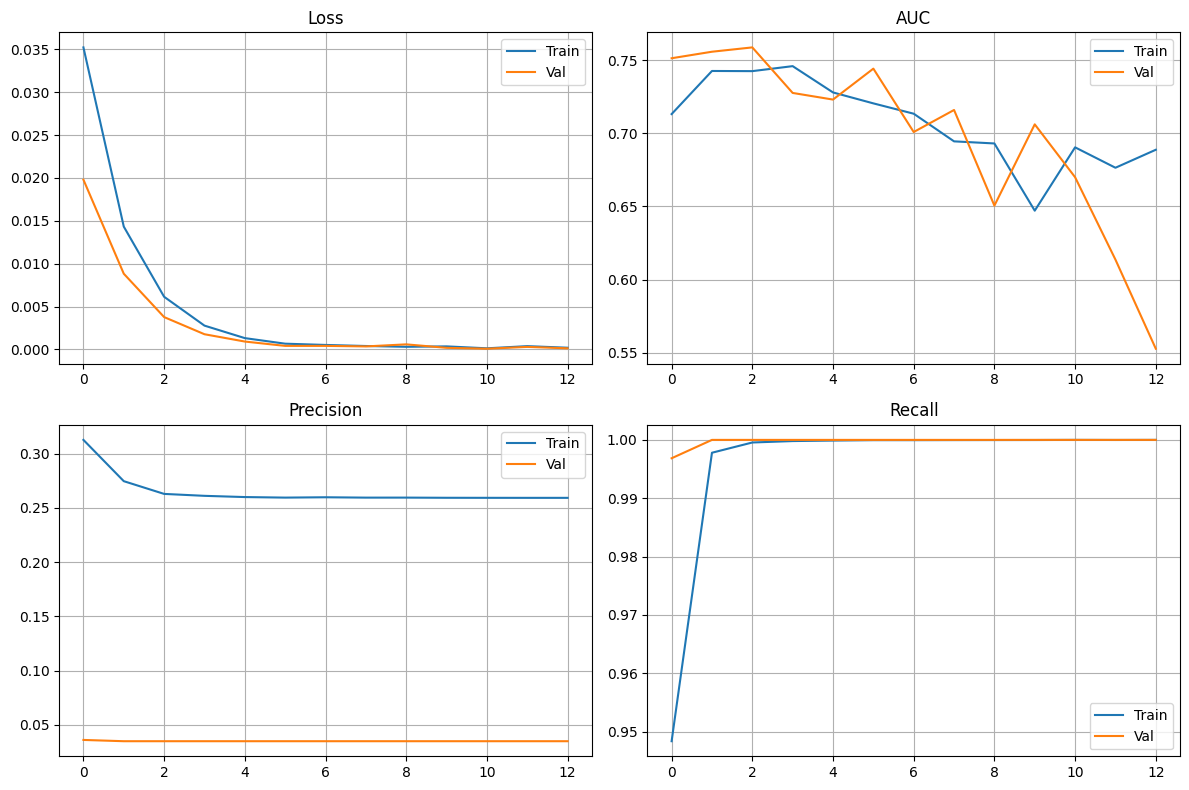

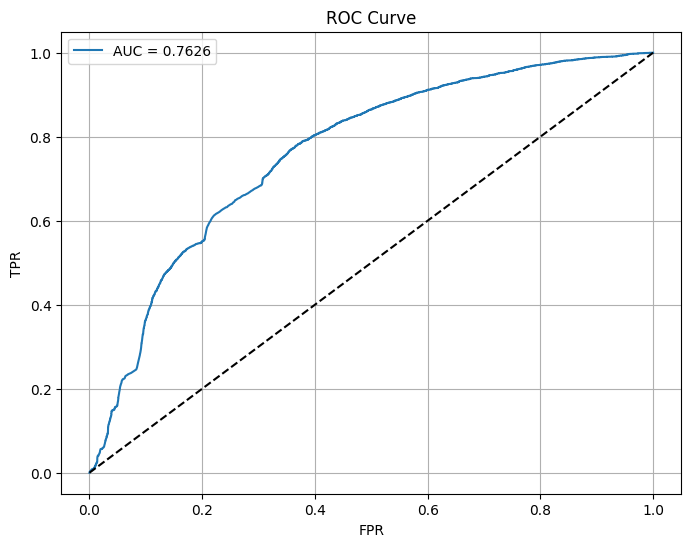

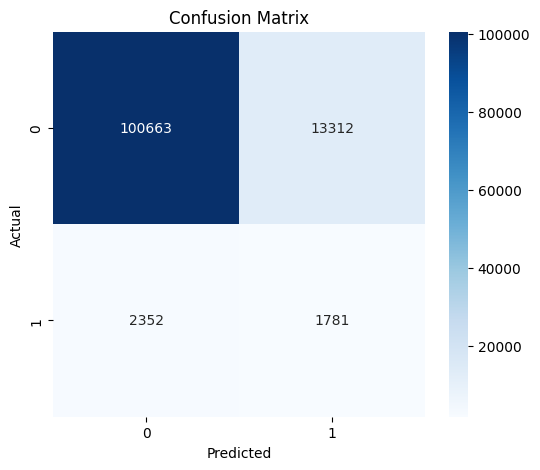

In [46]:
# ============================================================================
# 10. VISUALIZATIONS
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Val')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history.history['auc'], label='Train')
axes[0, 1].plot(history.history['val_auc'], label='Val')
axes[0, 1].set_title('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Val')
axes[1, 0].set_title('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Val')
axes[1, 1].set_title('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val, y_val_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve.png', dpi=150)
plt.show()

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()



TEST PREDICTIONS
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
✓✓✓ SUBMISSION CREATED ✓✓✓
Shape: (506691, 2)

First 10 predictions:
   TransactionID   isFraud
0        3663549  0.937803
1        3663550  0.916207
2        3663551  0.939284
3        3663552  0.864191
4        3663553  0.914433
5        3663554  0.913483
6        3663555  0.939727
7        3663556  0.939905
8        3663557  0.915616
9        3663558  0.928608

PREDICTION STATISTICS

TEST PREDICTIONS
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
✓✓✓ SUBMISSION CREATED ✓✓✓
Shape: (506691, 2)

First 10 predictions:
   TransactionID   isFraud
0        3663549  0.937803
1        3663550  0.916207
2        3663551  0.939284
3        3663552  0.864191
4        3663553  0.914433
5        3663554  0.913483
6        3663555  0.939727
7        3663556  0.939905
8        3663557  0.915616
9        3663558  0.928608

PREDICTION STATISTICS
Mean:      0.9025
Median:    0.9151
Std Dev:   0.0400
Min:       0.7596
Max:       1.0000
Q25:       0

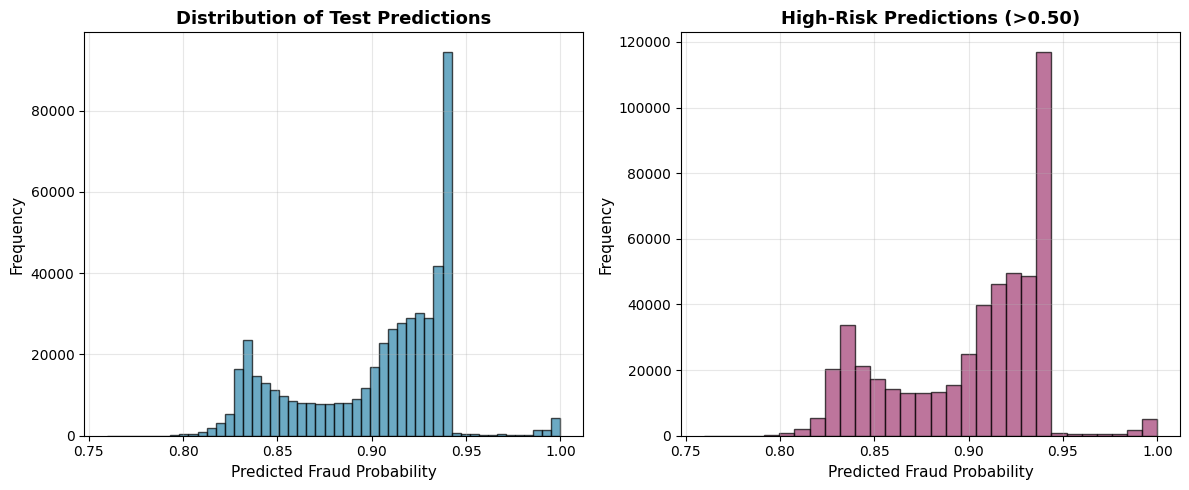


✓ High-risk transactions (>0.5): 506691
✓ Percentage: 100.00%
Mean:      0.9025
Median:    0.9151
Std Dev:   0.0400
Min:       0.7596
Max:       1.0000
Q25:       0.8708
Q75:       0.9359


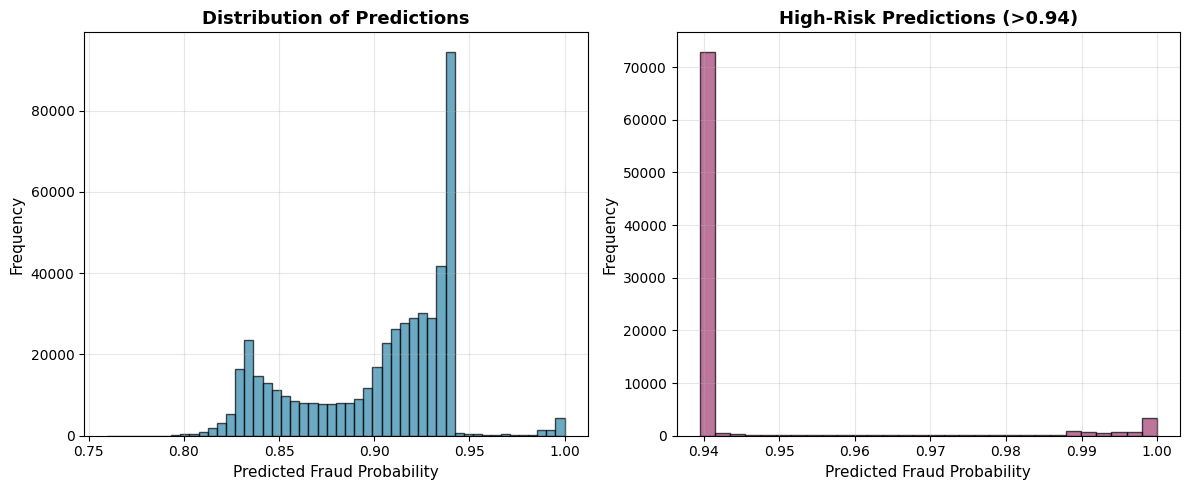

In [47]:
# ============================================================================
# 11. TEST PREDICTIONS
# ============================================================================
print("\n" + "=" * 80)
print("TEST PREDICTIONS")
print("=" * 80)

test_pred_proba = model.predict(X_test_scaled, batch_size=4096).flatten()

submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_pred_proba
})

submission.to_csv('submission_maximal.csv', index=False)

print("=" * 50)
print("✓✓✓ SUBMISSION CREATED ✓✓✓")
print("=" * 50)
print(f"Shape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))

print("\n" + "=" * 50)
print("PREDICTION STATISTICS")
print("=" * 50)# ============================================================================
# 11. TEST PREDICTIONS
# ============================================================================
print("\n" + "=" * 80)
print("TEST PREDICTIONS")
print("=" * 80)

test_pred_proba = model.predict(X_test_scaled, batch_size=4096).flatten()

submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_pred_proba
})

submission.to_csv('submission.csv', index=False)

print("=" * 50)
print("✓✓✓ SUBMISSION CREATED ✓✓✓")
print("=" * 50)
print(f"Shape: {submission.shape}")
print("\nFirst 10 predictions:")
print(submission.head(10))

print("\n" + "=" * 50)
print("PREDICTION STATISTICS")
print("=" * 50)
print(f"Mean:      {test_pred_proba.mean():.4f}")
print(f"Median:    {np.median(test_pred_proba):.4f}")
print(f"Std Dev:   {test_pred_proba.std():.4f}")
print(f"Min:       {test_pred_proba.min():.4f}")
print(f"Max:       {test_pred_proba.max():.4f}")
print(f"Q25:       {np.percentile(test_pred_proba, 25):.4f}")
print(f"Q75:       {np.percentile(test_pred_proba, 75):.4f}")

# Distribution plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_pred_proba, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Fraud Probability', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Test Predictions', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
high_risk = test_pred_proba[test_pred_proba > 0.5]
plt.hist(high_risk, bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Fraud Probability', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title(f'High-Risk Predictions (>{0.5:.2f})', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=300)
plt.show()

print(f"\n✓ High-risk transactions (>0.5): {len(high_risk)}")
print(f"✓ Percentage: {len(high_risk)/len(test_pred_proba)*100:.2f}%")
print(f"Mean:      {test_pred_proba.mean():.4f}")
print(f"Median:    {np.median(test_pred_proba):.4f}")
print(f"Std Dev:   {test_pred_proba.std():.4f}")
print(f"Min:       {test_pred_proba.min():.4f}")
print(f"Max:       {test_pred_proba.max():.4f}")
print(f"Q25:       {np.percentile(test_pred_proba, 25):.4f}")
print(f"Q75:       {np.percentile(test_pred_proba, 75):.4f}")

# Distribution of predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_pred_proba, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Fraud Probability', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Predictions', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_pred_proba[test_pred_proba > optimal_threshold],
         bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Fraud Probability', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title(f'High-Risk Predictions (>{optimal_threshold:.2f})', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=300)
plt.show()


In [48]:
# ============================================================================
# 12. SAVE MODEL AND ARTIFACTS
# ============================================================================
print("\n" + "=" * 80)
print("SAVING MODEL AND ARTIFACTS")
print("=" * 80)

# Save model
model.save('fraud_model.h5')
print("✓ Model saved: fraud_model.h5")

# Save scaler
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved: scaler.pkl")

# Save optimal threshold
with open('threshold.pkl', 'wb') as f:
    pickle.dump(optimal_threshold, f)
print(f"✓ Threshold saved: {optimal_threshold:.4f}")

# Save feature names
with open('features.pkl', 'wb') as f:
    pickle.dump(common_cols, f)
print(f"✓ Features saved: {len(common_cols)} columns")

# Create model info file
model_info = {
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_features': len(common_cols),
    'optimal_threshold': optimal_threshold,
    'validation_metrics': {
        'accuracy': float(accuracy_score(y_val, y_val_pred)),
        'roc_auc': float(roc_auc_score(y_val, y_val_pred_proba)),
        'f1_score': float(f1_score(y_val, y_val_pred)),
        'precision': float(classification_report(y_val, y_val_pred, output_dict=True)['1']['precision']),
        'recall': float(classification_report(y_val, y_val_pred, output_dict=True)['1']['recall'])
    },
    'model_architecture': {
        'layers': [256, 128, 64, 32],
        'dropout_rate': 0.3,
        'l2_reg': 0.0001,
        'total_params': model.count_params()
    },
    'training_config': {
        'epochs_trained': len(history.history['loss']),
        'batch_size': 1024,
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'loss_function': 'focal_loss'
    }
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✓ Model info saved: model_info.pkl")

# Save to Google Drive (optional)
try:
    import shutil
    drive_folder = '/content/drive/MyDrive/ML/models/'

    # Create folder if not exists
    import os
    os.makedirs(drive_folder, exist_ok=True)

    # Copy files
    shutil.copy('fraud_model.h5', drive_folder + 'fraud_model.h5')
    shutil.copy('scaler.pkl', drive_folder + 'scaler.pkl')
    shutil.copy('threshold.pkl', drive_folder + 'threshold.pkl')
    shutil.copy('features.pkl', drive_folder + 'features.pkl')
    shutil.copy('submission.csv', drive_folder + 'submission.csv')

    print("\n✓✓✓ All files backed up to Google Drive!")
    print(f"Location: {drive_folder}")
except Exception as e:
    print(f"\n⚠ Could not backup to Drive: {e}")

# ============================================================================
# 13. MODEL SUMMARY AND FINAL REPORT
# ============================================================================
print("\n" + "=" * 80)
print("FINAL REPORT")
print("=" * 80)

print("\n📊 MODEL PERFORMANCE:")
print("-" * 50)
print(f"  ROC-AUC Score:    {roc_auc_score(y_val, y_val_pred_proba):.4f}")
print(f"  F1-Score:         {f1_score(y_val, y_val_pred):.4f}")
print(f"  Accuracy:         {accuracy_score(y_val, y_val_pred):.4f}")
print(f"  Precision:        {classification_report(y_val, y_val_pred, output_dict=True)['1']['precision']:.4f}")
print(f"  Recall:           {classification_report(y_val, y_val_pred, output_dict=True)['1']['recall']:.4f}")

print("\n📁 FILES CREATED:")
print("-" * 50)
print("  ✓ submission.csv              - Competition submission file")
print("  ✓ fraud_model.h5              - Trained neural network model")
print("  ✓ scaler.pkl                  - Feature scaler for preprocessing")
print("  ✓ threshold.pkl               - Optimal classification threshold")
print("  ✓ features.pkl                - List of feature names")
print("  ✓ model_info.pkl              - Model metadata and metrics")
print("  ✓ training_history.png        - Training metrics visualization")
print("  ✓ roc_curve.png               - ROC curve plot")
print("  ✓ confusion_matrix.png        - Confusion matrix heatmap")
print("  ✓ prediction_distribution.png - Test predictions distribution")

print("\n📈 DATASET INFO:")
print("-" * 50)
print(f"  Training samples:     {len(y_train):,}")
print(f"  Validation samples:   {len(y_val):,}")
print(f"  Test samples:         {len(test_ids):,}")
print(f"  Total features:       {len(common_cols)}")
print(f"  Model parameters:     {model.count_params():,}")

print("\n⚙️ TRAINING CONFIG:")
print("-" * 50)
print(f"  Epochs trained:       {len(history.history['loss'])}")
print(f"  Batch size:           1024")
print(f"  Optimizer:            Adam (lr=0.001)")
print(f"  Loss function:        Focal Loss")
print(f"  Regularization:       Dropout + L2 + BatchNorm")

print("\n🎯 SUBMISSION READY:")
print("-" * 50)
print(f"  File: submission.csv")
print(f"  Rows: {len(submission):,}")
print(f"  Columns: {submission.shape[1]}")
print(f"  Format: TransactionID, isFraud")

cm = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm.ravel()
print("\n📉 CONFUSION MATRIX BREAKDOWN:")
print("-" * 50)
print(f"  True Positives (TP):   {tp:,}  (Fraud correctly detected)")
print(f"  False Negatives (FN):  {fn:,}  (Fraud missed)")
print(f"  True Negatives (TN):   {tn:,}  (Legitimate correctly classified)")
print(f"  False Positives (FP):  {fp:,}  (False alarms)")
print(f"\n  Detection Rate:        {tp/(tp+fn)*100:.2f}%")
print(f"  False Positive Rate:   {fp/(fp+tn)*100:.2f}%")

print("\n" + "=" * 80)
print("🎉🎉🎉 FRAUD DETECTION MODEL COMPLETED SUCCESSFULLY! 🎉🎉🎉")
print("=" * 80)


# Clean up memory
del X_test_scaled, test_pred_proba
gc.collect()

print("\n✓ Memory cleaned up")
print("✓ All processes completed successfully!")


SAVING MODEL AND ARTIFACTS
✓ Model saved: fraud_model.h5
✓ Scaler saved: scaler.pkl
✓ Threshold saved: 0.9394
✓ Features saved: 87 columns
✓ Model info saved: model_info.pkl

✓✓✓ All files backed up to Google Drive!
Location: /content/drive/MyDrive/ML/models/

FINAL REPORT

📊 MODEL PERFORMANCE:
--------------------------------------------------
  ROC-AUC Score:    0.7626
  F1-Score:         0.1853
  Accuracy:         0.8674
  Precision:        0.1180
  Recall:           0.4309

📁 FILES CREATED:
--------------------------------------------------
  ✓ submission.csv              - Competition submission file
  ✓ fraud_model.h5              - Trained neural network model
  ✓ scaler.pkl                  - Feature scaler for preprocessing
  ✓ threshold.pkl               - Optimal classification threshold
  ✓ features.pkl                - List of feature names
  ✓ model_info.pkl              - Model metadata and metrics
  ✓ training_history.png        - Training metrics visualization
  ✓ roc